# Final Report: OpenCV NLP Project

##### Dani Bojado and Matthew Mays

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os
import requests
from requests import get
from os import path
from bs4 import BeautifulSoup

import json
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import acquire as ac
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

- Scraped most starred OpenCV GitHub repositories 
- Wrote the python code necessary to extract the text of the README file for each page, and the primary language of the repository.
- Extracted a total of 150 repositories for our data set.

In [2]:
# Scrape data
url = 'https://github.com/search?o=desc&p={num}&q=OpenCV&s=stars&type=Repositories'
response = requests.get(url)

In [3]:
# Pull in repos using acquire function
urls = ac.get_all_urls() 
urls

['CMU-Perceptual-Computing-Lab/openpose',
 'openframeworks/openFrameworks',
 'Ewenwan/MVision',
 'oarriaga/face_classification',
 'PySimpleGUI/PySimpleGUI',
 'opencv/opencv',
 'vipstone/faceai',
 'spmallick/learnopencv',
 'opencv/opencv_contrib',
 'Hironsan/BossSensor',
 'hamuchiwa/AutoRCCar',
 'bytedeco/javacv',
 'justadudewhohacks/opencv4nodejs',
 'esimov/pigo',
 'peterbraden/node-opencv',
 'nuno-faria/tiler',
 'hybridgroup/gocv',
 'jrosebr1/imutils',
 'bijection/sistine',
 'kelaberetiv/TagUI',
 'HuTianQi/SmartOpenCV',
 'soruly/trace.moe',
 'Roujack/mathAI',
 'shimat/opencvsharp',
 'anandpawara/Real_Time_Image_Animation',
 'CodecWang/OpenCV-Python-Tutorial',
 'mapillary/OpenSfM',
 'MasteringOpenCV/code',
 'makelove/OpenCV-Python-Tutorial',
 'amusi/AI-Job-Notes',
 'skvark/opencv-python',
 'abhiTronix/vidgear',
 'kongqw/OpenCVForAndroid',
 'opentrack/opentrack',
 'changwookjun/StudyBook',
 'tebelorg/RPA-Python',
 'nagadomi/lbpcascade_animeface',
 'andrewssobral/bgslibrary',
 'oreillyme

In [4]:
# Store repos into a json file
df = pd.read_json('data.json')

In [5]:
# 150 repos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             150 non-null    object
 1   language         144 non-null    object
 2   readme_contents  150 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


## Prepare

- Built a dataset
- Counted programming languages for each repo
- Prepared and cleaned data

In [6]:
# Built dataframe
df

,repo,language,readme_contents
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw...."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo..."
...,...,...,...
145,jerry1900/faceRecognition,Python,# faceRecognition\n利用OpenCV、CNN进行人脸识别\n万壑，4978...
146,lixiaoshaxing/MultiMediaLearn,C,# MultiMediaLearn\n多媒体学习：图片处理，音视频处理，相机使用，OpenG...
147,WL-Amigo/waifu2x-converter-cpp,C++,# waifu2x (converter only version)\n\nThis is ...
148,atulapra/Emotion-detection,Python,# Emotion detection using deep learning\n\n## ...


In [7]:
# Count programming languages in repos from dataframe
language_count = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
language_count.columns = ['n', 'percent']
language_count

,n,percent
Python,61,0.423611
C++,47,0.326389
Java,7,0.048611
JavaScript,6,0.041667
Jupyter Notebook,5,0.034722
Go,3,0.020833
Objective-C,2,0.013889
C#,2,0.013889
Shell,2,0.013889
C,1,0.006944


In [8]:
# Prepare data
df['text_cleaned'] = df.readme_contents.apply(prepare.basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(prepare.tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(prepare.lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(prepare.remove_stopwords)
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...


In [9]:
# Create 'words' variable
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]

# Add 'words' column to dataframe
# Column will contain lists of separated words in each repo
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack..."


## Explore

### What are the most common words in READMEs?

### Most Common Single Words

In [10]:
# Create words variables for Python, C++, and All
python_words = ' '.join(df[df.language=='Python'].text_filtered)
c_plus_plus_words = ' '.join(df[df.language=='C++'].text_filtered)
all_words = ' '.join(df.text_filtered)

python_words = re.sub(r'\s.\s', '', python_words)
c_plus_plus_words = re.sub(r'\s.\s', '', c_plus_plus_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [11]:
# Word Frequency 
python_freq = pd.Series(python_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

all_freq.head()

&#9;      925
image     887
opencv    765
build     498
using     447
dtype: int64

In [12]:
# Word Count for 'All', 'Python', and C++
word_counts = (pd.concat([all_freq, python_freq, c_plus_plus_freq], axis=1, sort=True)
               .set_axis(['All', 'Python', 'C++'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.sort_values(by='All', ascending=False).head(10)

,All,Python,C++
&#9;,925,105,534
image,887,600,153
opencv,765,156,244
build,498,25,222
using,447,156,138
file,394,172,79
tdtd,383,383,0
install,376,112,77
use,350,113,135
python,346,227,44


In [13]:
# Create variables for series
single_python_words = pd.Series(list(nltk.ngrams(python_words.split(), 1))).value_counts().head(20) 
single_c_plus_plus_words = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 1))).value_counts().head(20)
single_all_words = pd.Series(list(nltk.ngrams(all_words.split(), 1))).value_counts().head(20)

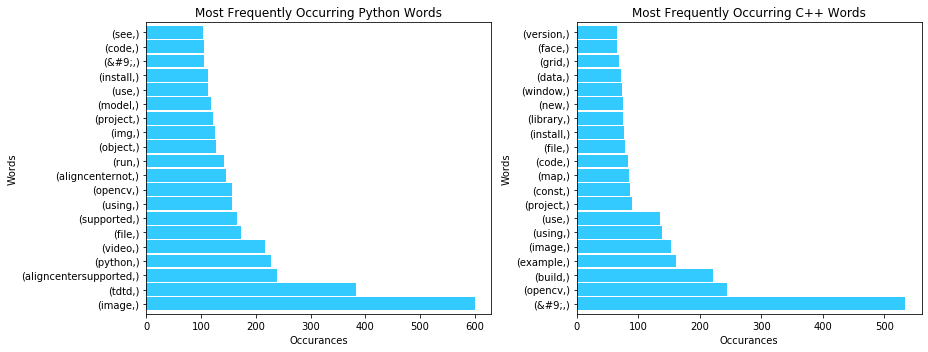

In [14]:
# Single Word Subplots (Python and C++) 
single_python_words.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
single_c_plus_plus_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))
single_all_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
single_python_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
single_c_plus_plus_words.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Occurances')

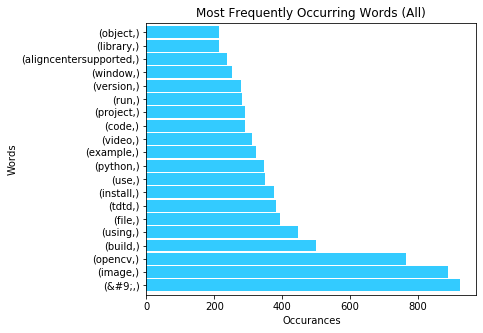

In [15]:
# Single Word Subplots (All) 
plt.subplot(121)
single_all_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Words (All)')
plt.ylabel('Words')
plt.xlabel('Occurances')

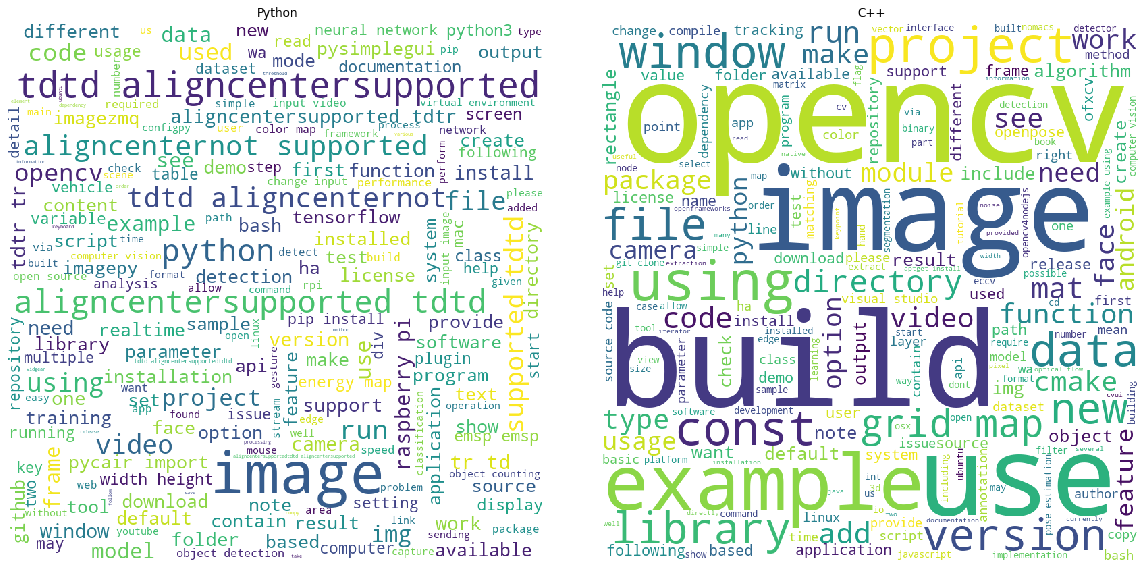

In [16]:
# Single Word, Word Clouds
python_cloud = WordCloud(background_color='white',
                      height=800, width=800).generate(python_words)

c_plus_plus_cloud = WordCloud(background_color='white', 
                      height=800, width=800).generate(c_plus_plus_words)

plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(python_cloud)
axs[1].imshow(c_plus_plus_cloud)

axs[0].set_title('Python')
axs[1].set_title('C++')

for ax in axs: ax.axis('off')

### Do different programming languages use a different number of unique words?

### Most Common Bigrams

In [17]:
# Added 'Bigram' column to dataframe
df['bigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,..."


In [18]:
# Create variables for series
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2))).value_counts().head(20) 
c_plus_plus_bigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 2))).value_counts().head(20)

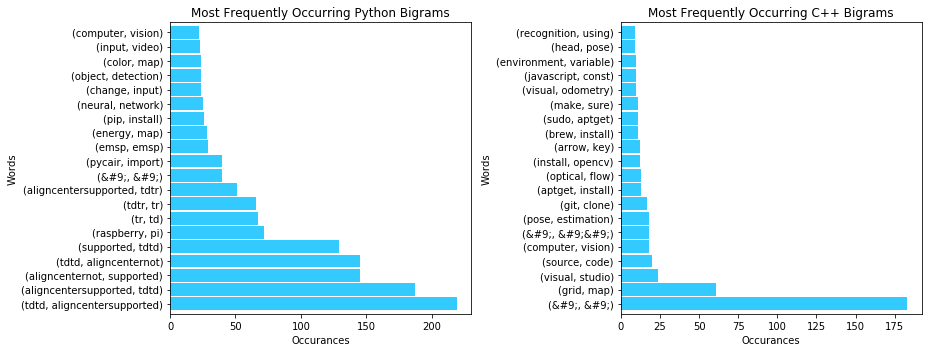

In [19]:
# Bigram Subplots 
python_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
python_bigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
c_plus_plus_bigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

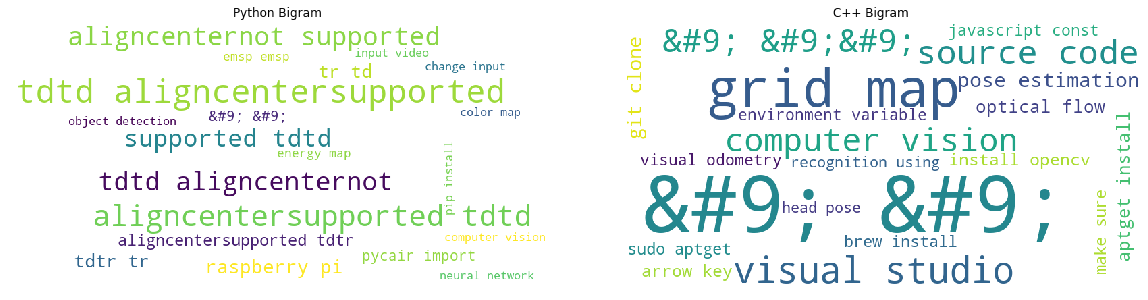

In [20]:
# Bigram Word Clouds
python_data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
c_plus_plus_data = {k[0] + ' ' + k[1]: v for k, v in c_plus_plus_bigrams.to_dict().items()}

python_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_data)

c_plus_plus_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_data)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_bigram_cloud)
axs[1].imshow(c_plus_plus_bigram_cloud)

axs[0].set_title('Python Bigram')
axs[1].set_title('C++ Bigram')

for ax in axs: ax.axis('off')

### Most Common Trigrams

In [21]:
# Added 'Trigram' column to dataframe
df['trigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams,trigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio...","[(mvision, machine), (machine, vision), (visio..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext...","[(repository, opencvs), (opencvs, extra), (ext..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s...","[(p, aligncenter), (aligncenter, img), (img, s..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp...","[(opencv, open), (open, source), (source, comp..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,...","[(div, aligncenter), (aligncenter, img), (img,..."


In [22]:
# Create variables for series
python_trigrams = pd.Series(list(nltk.ngrams(python_words.split(), 3))).value_counts().head(20)
c_plus_plus_trigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 3))).value_counts().head(20)

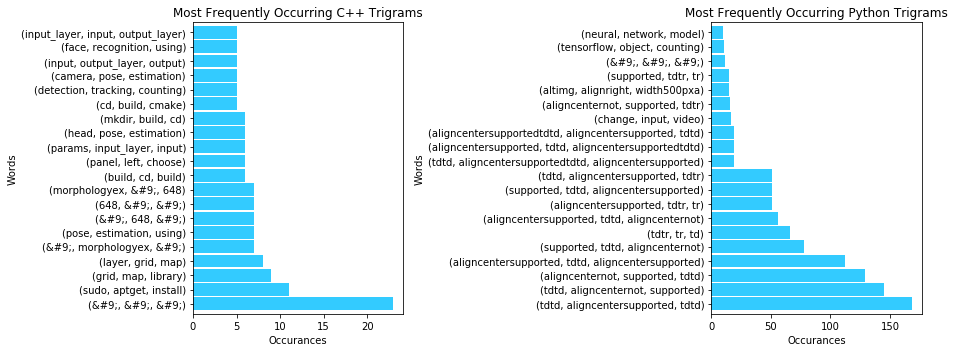

In [23]:
# Trigram Subplots 
# Switched Python and C++ graphs around to better align in this format
# Pay attention to the titles and labels
python_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
c_plus_plus_trigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
python_trigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

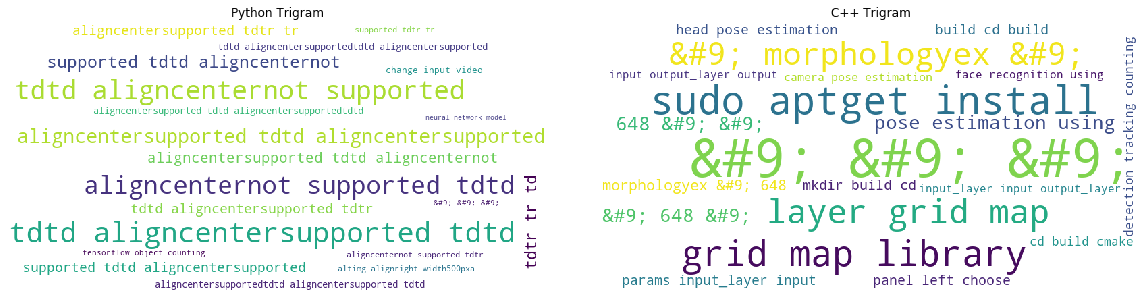

In [24]:
# Trigram Word Clouds
python_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
c_plus_plus_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in c_plus_plus_trigrams.to_dict().items()}

python_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_tridata)

c_plus_plus_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_tridata)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_trigram_cloud)
axs[1].imshow(c_plus_plus_trigram_cloud)

axs[0].set_title('Python Trigram')
axs[1].set_title('C++ Trigram')

for ax in axs: ax.axis('off')

### What does the distribution of IDFs look like for the most common words?

### Does the length of the README vary by programming language?

## Model 

- Use the programming language of the repository as a predictive label.  


- Fit different models and using different representations of the text (e.g. simple bag of words, TF-IDF values).  


- Built a function that will take in the text of a README file and predict the programming language of repo.  

### Train, Validate, Test

In [25]:
# train_validate, test = train_test_split(df[['language', 'readme_contents']], 
                                        #stratify=df.language, 
                                        #test_size=.2)

# train, validate = train_test_split(train_validate, 
                                   #stratify=train_validate.language, 
                                   #test_size=.25)

### Bag of Words

### TF-IDF

### Function

## Conclusions/Takeaways

- Even though OpenCV is primarly written in C++, most words repos are written in Python  



- Repo Languages (out of 150 total most starred repos explored):  
    - Python 42.3% ; 61 repos  
    - C++ 32.6%, 47 repos  
    - Java 4.8%, 7 repos  
    
   
- We choose to only explore Python and C++ repos because there are the most significant   



- Combined total of 108 repos explored



- Most common words for Python and C++ combined are  &#9 ; , image, and opencv  



- Curious to know the meaning behind  &#9 ; ,could not find anything over it through Google search

## Future Investigations

- Are similar patterns seen across other computer vision software repos, such as (Matlab, TensorFlow, and SimpleCV)?